## Objective of the Notebook
(NoobAtem) After downloading all files and collecting the necessary data to our raw folder, were going to proceed trying methods in cleaning the audio. There are standards were going to follow when handling variety of audio source. Known techniques would apply and thus the summary of the notebook is listed
* Resampling
* Trimming
* Silence Removal
* Noise Reduction
* Filtering

### Prerequisite Libraries

In [2]:
import librosa
import matplotlib.pyplot as plt
import librosa.display
import numpy
import os
import yaml
import numpy as np
import pandas as pd
import IPython.display as ipd

### Define Relevant Paths

In [3]:
# The main parent folder for handling in all sorts of data
DATA_P: str = "../data"

RAW_P: str = os.path.join(DATA_P, "raw") # Data that we've formatted and designed/collected
EXTERN_P: str = os.path.join(DATA_P, "external") # 3rd party dataset
INTERIM_P: str = os.path.join(DATA_P, "interim") # Dataset that is being process and its under commission
PROCESS_P: str = os.path.join(DATA_P, "processed") # Processed data ready to be used

# The main parent for handling configs
CONFIG_P: str = "../configs"

DATA_CONF_P: str = os.path.join(CONFIG_P, "dataset_config.yaml")
config: dict = None
with open(DATA_CONF_P, "r") as yml_file:
    config = yaml.safe_load(yml_file)

### Testing Transformation

Before applying each methods to our audio, lets first try the method with a single sample. We are going to take a sample from a door sound (Make sure that there is content in raw)

In [4]:
# Get a sample
RAW_DOOR_P: str = os.path.join(RAW_P, "door")
sample_audio: str = os.path.join(RAW_DOOR_P, os.listdir(RAW_DOOR_P)[0])
audio, sr = librosa.load(sample_audio)
librosa.get_duration(y=audio, sr=sr)

5.0

Now, were going to split this audio into 500ms segments

In [5]:
duration_ms: int = 500
segment_sample: int = int(sr * duration_ms / 1000)
segments: list = [audio[i: i + segment_sample] for i in range(0, len(audio), segment_sample)]
for idx, segment in enumerate(segments):
    print(idx ,librosa.get_duration(y=segment, sr=sr))

0 0.5
1 0.5
2 0.5
3 0.5
4 0.5
5 0.5
6 0.5
7 0.5
8 0.5
9 0.5


Next we are goint to add an overlap to have an smoother transition

In [6]:
overlap_ms: int = 100
overlap_sample: int = int(sr * overlap_ms / 1000)
segments: list = []
start: int = 0
while start < len(audio):
    end: int = start + segment_sample
    segments.append(audio[start:end])
    start += segment_sample - overlap_sample

for idx, segment in enumerate(segments):
    print(idx ,librosa.get_duration(y=segment, sr=sr))

0 0.5
1 0.5
2 0.5
3 0.5
4 0.5
5 0.5
6 0.5
7 0.5
8 0.5
9 0.5
10 0.5
11 0.5
12 0.2


Were going to create a function now that outputs an segmented and overlap audio 

In [7]:
# Milliseconds
def segment_overlap_audio(audio: np.array, sr: int, duration: int = 500, overlap: int = 100) -> list:
    segment: int = int(sr *  duration/ 1000)
    overlap_segment: int = int(sr * overlap / 1000)
    segments: list = []
    start: int = 0
    while start < len(audio):
        end: int = start + segment
        segments.append(audio[start:end])
        start += segment - overlap_segment

    return segments

In [8]:
_segment: list = segment_overlap_audio(audio, sr)
for idx, segment in enumerate(_segment):
    print(idx ,librosa.get_duration(y=segment, sr=sr))

0 0.5
1 0.5
2 0.5
3 0.5
4 0.5
5 0.5
6 0.5
7 0.5
8 0.5
9 0.5
10 0.5
11 0.5
12 0.2


The model wouldn't be possible without the spectogram which makes our CV's

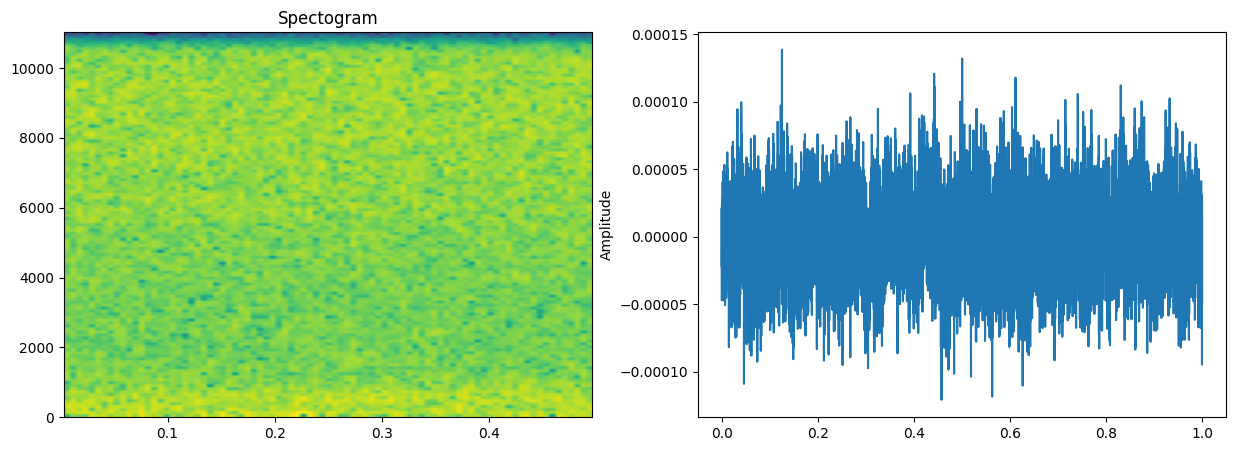

In [9]:
# View spectogram from the given sample
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].title.set_text("Spectogram")
ax[0].specgram(_segment[0], Fs=sr)
ax[1].set_ylabel('Amplitude')
ax[1].plot(np.linspace(0,1,len(_segment[0])), _segment[0])

For convinience, I'm going to make it as a function

In [10]:
def comp_spec_wav(audio: np.array, sr: int):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].title.set_text("Spectogram")
    ax[0].specgram(audio, Fs=sr)
    ax[1].set_ylabel('Amplitude')
    ax[1].plot(np.linspace(0,1,len(audio)), audio)

Add white noise to the said spectogram

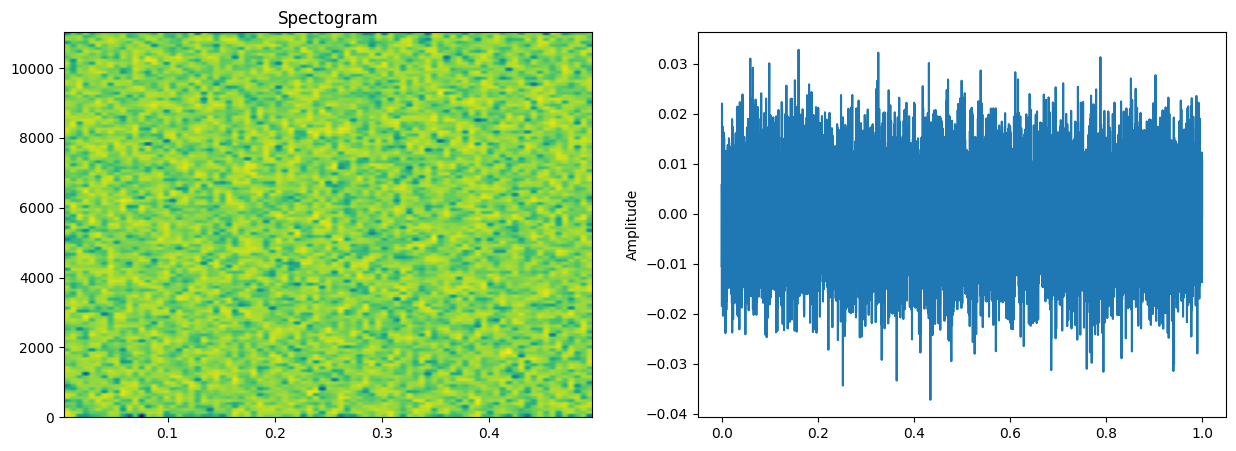

In [11]:
wav_n: np.array = _segment[0] + 0.009*np.random.normal(0, 1, len(_segment[0]))
comp_spec_wav(wav_n, sr)
ipd.Audio(wav_n, rate=sr)

Time shifting is the next to the list

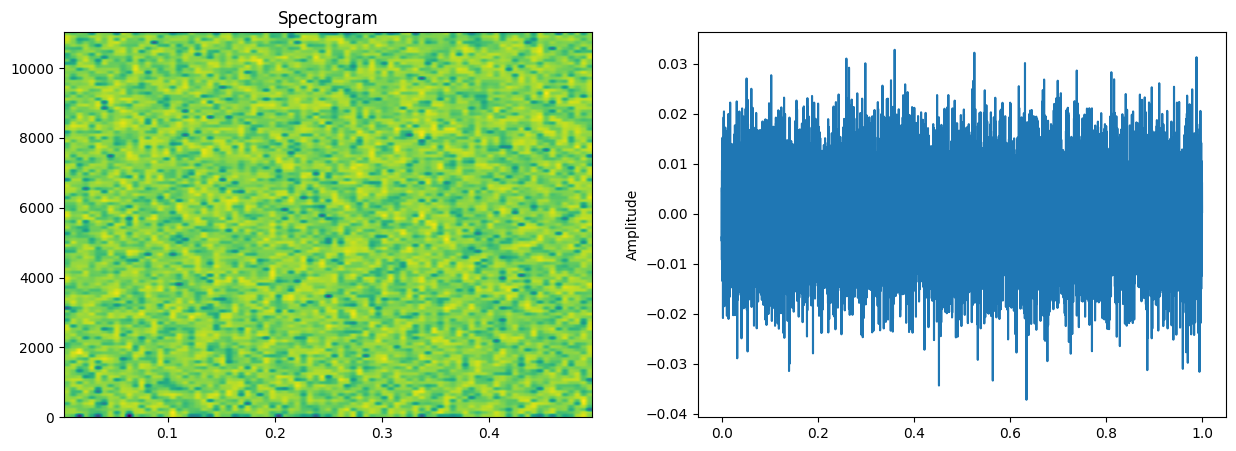

In [12]:
wav_roll: np.array = np.roll(wav_n, int(sr/10))
comp_spec_wav(wav_roll, sr)

Time stretching would allow us to modify the duration with minizing the expense of pitch

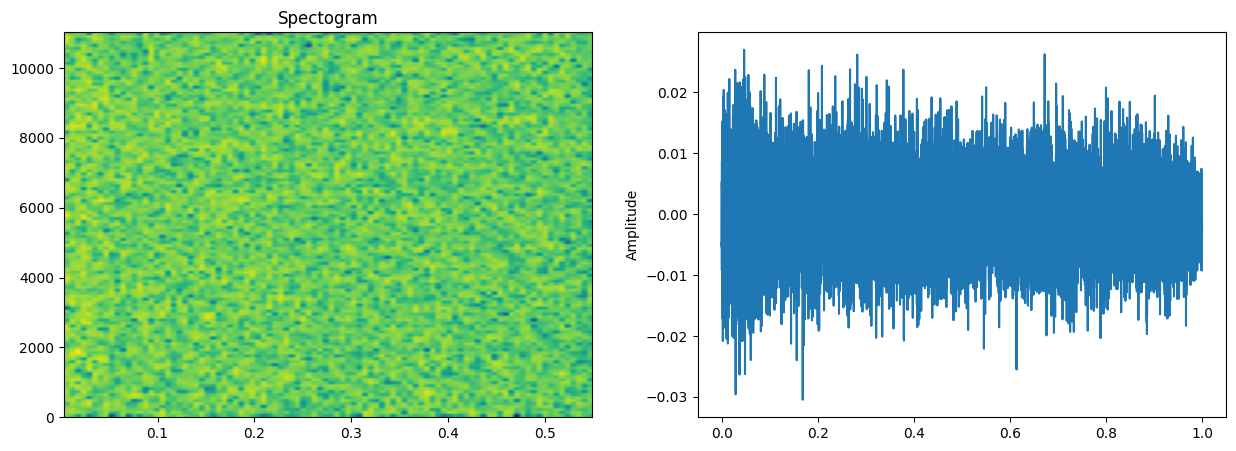

In [13]:
factor: float = 0.9
wav_stretch: np.array = librosa.effects.time_stretch(y=wav_roll, rate=factor)
comp_spec_wav(wav_stretch, sr)

In [14]:
wav_stretch.shape

(12250,)

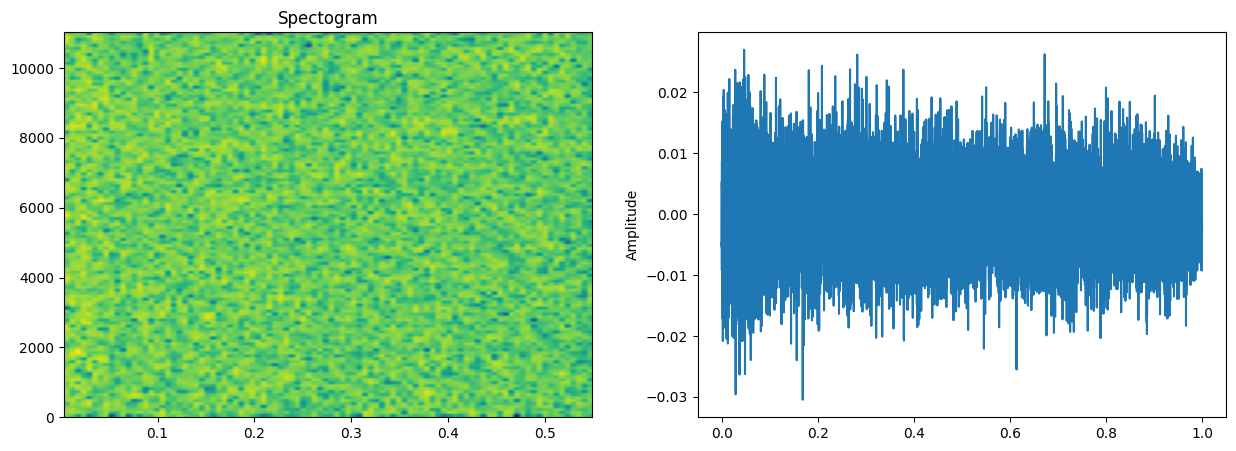

In [16]:
wav_pitch_shift: np.array = librosa.effects.pitch_shift(wav_stretch, sr=sr, n_steps=-5)
comp_spec_wav(wav_stretch, sr)